### In this notebook the shallow water eqation will be solved using a linearized Riemann solver to first order

We update the cell approximations by
$$
Q_i^{n+1} = Q_i^n - \frac{\Delta t}{\Delta x} ( \mathcal{A}^+\Delta Q_{i-1/2} + \mathcal{A}^-\Delta Q_{i+1/2}).
$$

If we let the maximal wavespeed be denoted $s_{\text{max}}$, we require
$$
\frac{s_{\text{max}} \Delta t}{\Delta x} \leq 1.
$$

Using the waves and speeds from an approximate Riemann solution, we define
$$
\mathcal{A}^-\Delta Q_{i-1/2} = \sum_{p=1}^{M_w} (s_{i-1/2}^p)^- \mathcal{W_{i-1/2}}^p,
$$
$$
\mathcal{A}^+\Delta Q_{i-1/2} = \sum_{p=1}^{M_w} (s_{i-1/2}^p)^+ \mathcal{W_{i-1/2}}^p.
$$

Now, we need to determine the waves and wave speeds.


At each cell interface, we replace the nonlinear problem 
$$
q_t + f(q)_x = 0
$$

by the linearlized problem

$$
\hat q_t + \hat A_{i-1/2} q_x = 0.
$$

The matrix $\hat A_{i-1/2}$ should satisfy the following properties:

* $\hat A_{i-1/2}$ is diagonalizable with real eigenvalues $\rightarrow$ hyperbolic

* $\hat A_{i-1/2} \text{ } \rightarrow f'(\bar q) \text{  as } Q_{i-1}, Q_i \rightarrow \bar q$.


The approximate Riemann solution consists of m waves proportional to the eigenvectors $\hat r_{i-1/2}^p$ of $\hat A_{i-1/2}$, with speeds $s_{i-1/2}^p = \hat \lambda_{i-1/2}^p$. 

We solve 
$$
Q_i - Q_{i-1} = \sum_{p=1}^m \alpha_{i-1/2}^p \hat r_{i-1/2}^p,
$$
for the coefficients $\alpha_{i-1/2}^p$ and set the waves $W_{i-1/2}^p = \alpha_{i-1/2}^p \hat r_{i-1/2}^p$.

One choice of the approximation matrix $\hat A_{i-1/2}$ is 
$$
\hat A_{i-1/2} = f'(\hat Q_{i-1/2})
$$,
with $\hat Q_{i-1/2}$ being some average between $Q_i \text{ and } Q_{i-1}$.

For the first attempt just use $\hat Q_{i-1/2} = (Q_i + Q_{i-1})/2$.


#### Shallow water equation
We solve this first, since plots of solutions are easily available.

$\textbf{Shallow water:}$

$$
q = 
\begin{bmatrix}
h\\
hu
\end{bmatrix} 
= 
\begin{bmatrix}
q^1\\
q^2
\end{bmatrix},
$$

$$
f(q) = 
\begin{bmatrix}
hu\\
hu^2 + \frac12 gh^2
\end{bmatrix} 
= 
\begin{bmatrix}
q^2\\
(q^2)^2/q^1 + \frac12 g(q^1)^2
\end{bmatrix},
$$

$$
f'(q) =
\begin{bmatrix}
0 & 1\\
-(q^2/q^1)^2 + gq^1 & 2q^2/q^1
\end{bmatrix}
= 
\begin{bmatrix}
0 & 1\\
-u^2 + gh & 2u
\end{bmatrix}.
$$


We need eigenvalues and eigenvectors of this matrix.
The eigenvalues of $f'(q)$ are
$$
\lambda^1 = u - \sqrt{gh}, \quad \lambda^2 = u + \sqrt{gh},
$$
and the eigenvectors are
$$
r^1 = 
\begin{bmatrix}
1 \\
u - \sqrt{gh}
\end{bmatrix}
, \quad
r^2 = 
\begin{bmatrix}
1 \\
u + \sqrt{gh}
\end{bmatrix}
$$



Algorithm overview:

1. Calculate averages of the previous time step $\hat Q_{i-1/2}^n = (Q_{i}^n + Q_{i-1}^n)/2$.

2. Calculate the approximation matrix $\hat A_{i-1/2} = f'(\hat Q_{i-1/2}^n)$.

3. Find eigenvalues and eigenvectors of the approximation matrix  $\hat A_{i-1/2}$.

4. Solve the linear system $Q_i^n - Q_{i-1}^n = \sum_{p=1}^m \alpha_{i-1/2}^p \hat r_{i-1/2}^p$, and set $W_{i-1/2}^p = \alpha_{i-1/2}^p \hat r_{i-1/2}^p$,  and set $s_{i-1/2}^p = \hat \lambda_{i-1/2}^p$.

5. Update the cell averages as $Q_i^{n+1} = Q_i^n - \frac{\Delta t}{\Delta x} ( \mathcal{A}^+\Delta Q_{i-1/2} + \mathcal{A}^-\Delta Q_{i+1/2})$, with 
$\mathcal{A}^{\pm}\Delta Q_{i-1/2} = \sum_{p=1}^{M_w} (s_{i-1/2}^p)^{\pm} \mathcal{W_{i-1/2}}^p$.



In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt


In [6]:
def gaussian(sigma, mu, x):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2) / (sigma * np.sqrt(2 * np.pi))

In [2]:
# a = torch.tensor([[1,2,3], [4,4,5]])
# print(a.shape)
# torch.tensor([1., torch.sqrt(a[0])])
# #a[1].shape

In [94]:
g = 1.0
def Jacobi_properties(q):
    '''
    Calculates some properties of the Jacobi matrix evaluated at q.
    Specifically returns eigenvalues and eigenvectors

    Args:
        q: torch.tensor of shape (2,N)
    '''

    
    h = q[0] # torch.tensor of shape (N,)
    u = torch.zeros_like(h)
    for i in range(len(h)):
        if h[i] != 0:
            u[i] = q[1,i] / h[i]


    eigval1 = u - torch.sqrt(g*h)
    eigval2 = u + torch.sqrt(g*h)
    # eigvec1 = torch.tensor([1., eigval1])
    # eigvec2 = torch.tensor([1., eigval2])

    return eigval1, eigval2#, eigvec1, eigvec2

#### Specific example - One hump of water

$u_0 = 0$

h has a "hump" (Gauss kernel) in the middle with amplitude around 1 (choose 1), centered around 0 and almost zero outside (-1,1).

In [28]:
# Generate data for example
x = np.linspace(-5, 5, 300)
y = gaussian(0.25, 0, x)

# Convert to torch tensors
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

q_0 = torch.stack([y, torch.zeros_like(y)], dim=0) # torch.tensor of shape (2,N)
# Jacobi_properties(q_0)

#### Linearixed Riemann approximation algorithm

In [110]:
def shallow_water(q_init, T, max_iter = 100):
    """
    Solve the shallow water equations for a given initial distribution.

    Args:
        q_init (torch.Tensor): Initial distribution of shape (2, N + 2). (+2 bc of ghost cells. Alternatively, 
        these could be added after.)
        T (float): Final time.

    Returns:
        torch.Tensor: Final solution of shape (2, N).
    """
    N = q_init.shape[1] - 2
    dx = 1. / q_init.shape[1]
    t = 0
    q = q_init.clone()

    curr_iter = 0
    while t < T:
        q_prev = q.clone()

        # Averaging at interfaces
        q_avg = torch.stack([(q_prev[0,1:] + q_prev[0,:-1]) / 2,
                       (q_prev[1,1:] + q_prev[1,:-1]) / 2], dim=0)
        
        # Calculate eigenvalues and eigenvectors at interfaces
        eigval1, eigval2 = Jacobi_properties(q_avg)
        # Note that eigenvectors can be constructed from eigenvalues
        # When eigenvalues are calculated, the maximal timestep can be calculated:
        dt = dx / (torch.max(torch.max(torch.abs(eigval1)),torch.max(torch.abs(eigval2))))
        print(dt, (torch.max(torch.max(torch.abs(eigval1)),torch.max(torch.abs(eigval2)))))

        plt.plot(q_prev[0])
        plt.show()
        if not dt < 0.1:
            plt.plot(q_prev[0])
            plt.show()
            # plt.plot(q_avg[0])
            # plt.plot(q_avg[1])
            # plt.show()
            # print(q_avg)
            # print(eigval1, eigval2)
        # Solving linear system
        lhs = q_prev[:,1:] - q_prev[:,:-1]
        alpha = torch.zeros(2, N+1) # 1 less interface then number of cells

        for i in range(N+1): # Does this need to be a for loop? -> Remove the for loop....
            # type(torch.stack([torch.ones(2),torch.tensor([eigval1[i], eigval2[i]])], dim=0))
            A = torch.stack([torch.ones(2),torch.tensor([eigval1[i], eigval2[i]])], dim=0)
            # print(f"i = {i},\nA = {A}\n")
            alpha[:,i] = torch.linalg.solve(A, lhs[:,i])

        # Calculating the waves
        wave1 = alpha[0,:] * torch.stack([torch.ones(N+1), eigval1], dim=0)
        wave2 = alpha[1,:] * torch.stack([torch.ones(N+1), eigval2], dim=0)

        # Calculate the fluctuations
        A_plus = torch.zeros(2,N+1)
        A_minus = torch.zeros(2,N+1)
        for i in range(N+1):
            A_plus[:,i] = torch.max(torch.tensor(0), eigval1[i]) * wave1[:,i] + torch.max(torch.tensor(0), eigval2[i]) * wave2[:,i]
            A_minus[:,i] = torch.max(torch.tensor(0), -eigval1[i]) * wave1[:,i] + torch.max(torch.tensor(0), -eigval2[i]) * wave2[:,i]
        # print(q.shape)
        # print(q_prev.shape)
        # print(A_plus.shape)
        # print(A_minus.shape)
        q[:,1:-1] = q_prev[:,1:-1] - dt/dx * (A_plus[:,:-1] + A_minus[:,1:])

        # Issue: h becomes negative!!

        t = t + dt

        curr_iter += 1
        if curr_iter > max_iter:
            break
    print(t)
    return q

tensor(0.0028) tensor(1.1824)


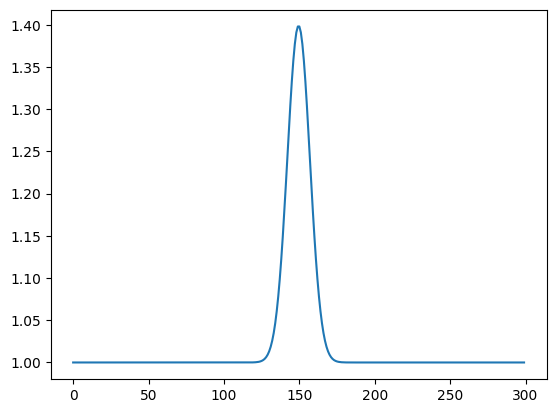

tensor(0.0028) tensor(1.1867)


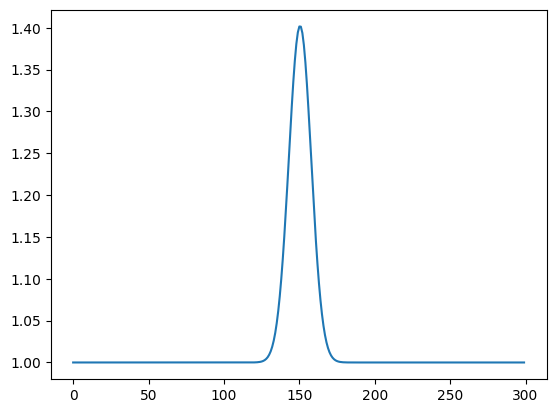

tensor(0.0028) tensor(1.1913)


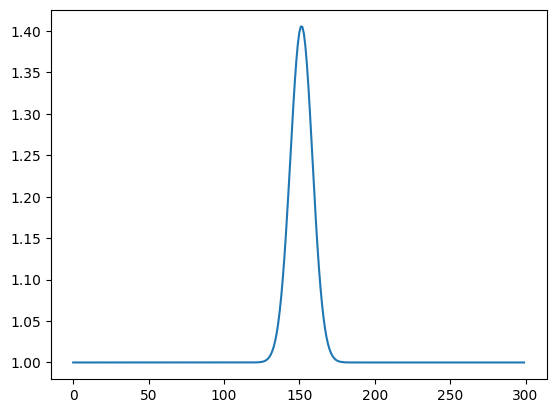

tensor(0.0028) tensor(1.1961)


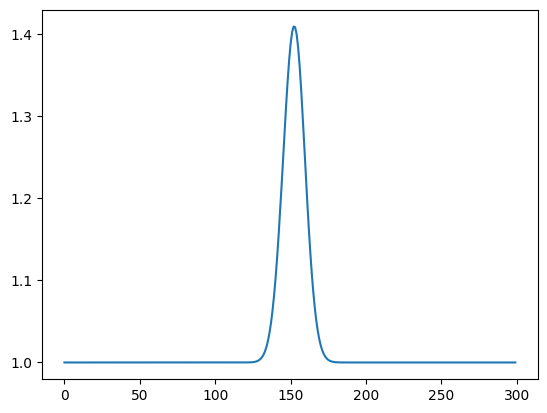

tensor(0.0028) tensor(1.2012)


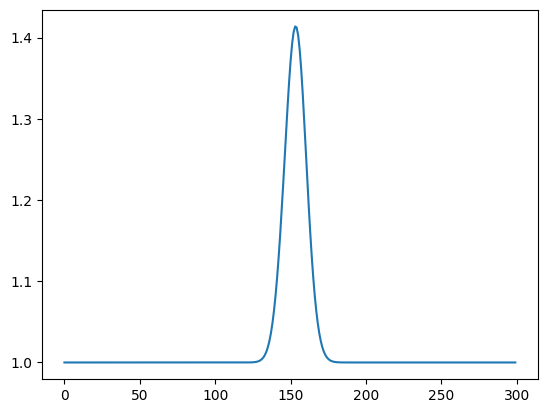

tensor(0.0028) tensor(1.2067)


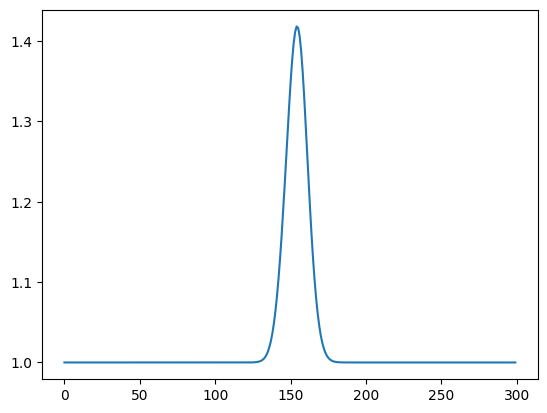

tensor(0.0027) tensor(1.2126)


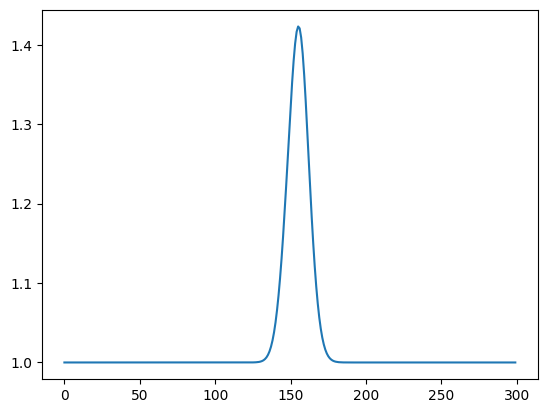

tensor(0.0027) tensor(1.2194)


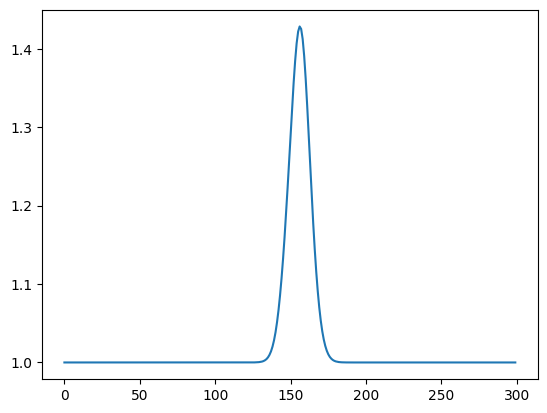

tensor(0.0027) tensor(1.2269)


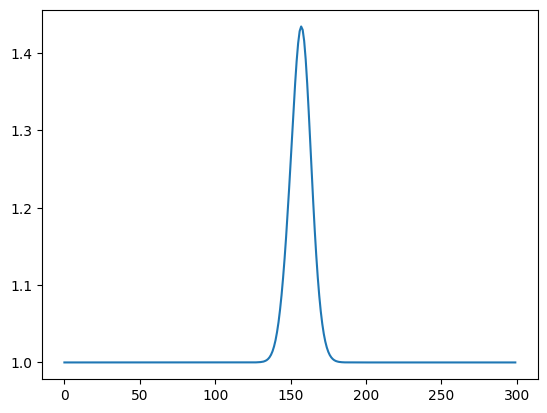

tensor(0.0027) tensor(1.2351)


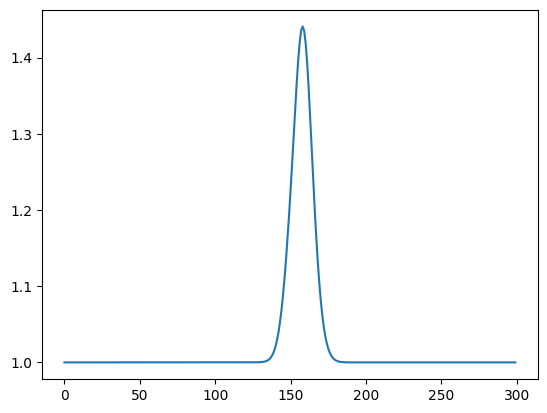

tensor(0.0027) tensor(1.2442)


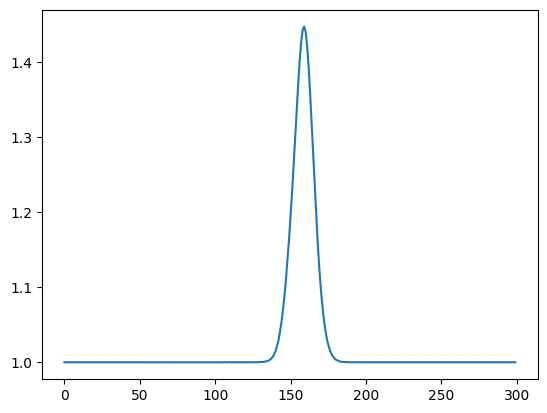

tensor(0.0027) tensor(1.2544)


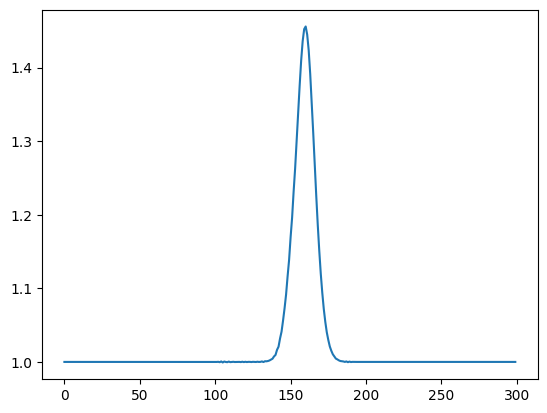

tensor(0.0026) tensor(1.2650)


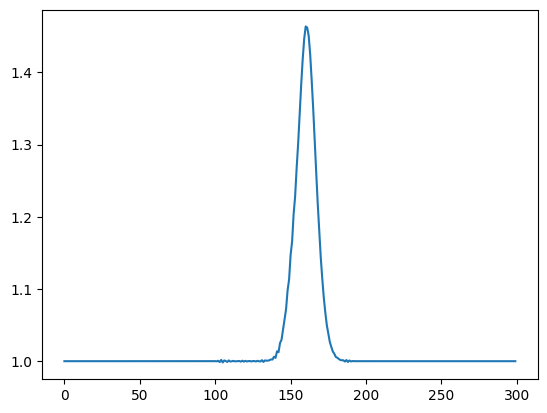

tensor(0.0026) tensor(1.2755)


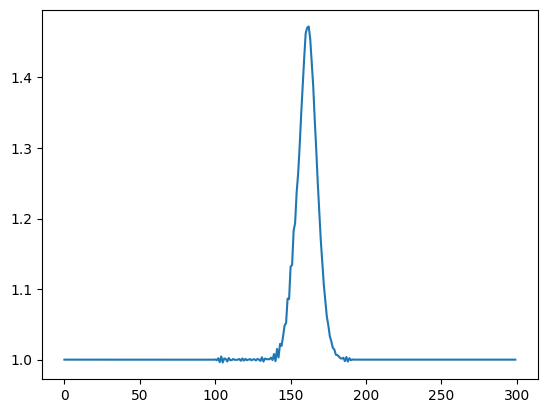

tensor(0.0026) tensor(1.2915)


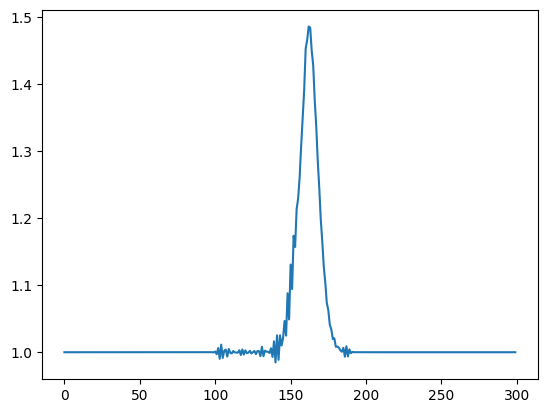

tensor(0.0025) tensor(1.3149)


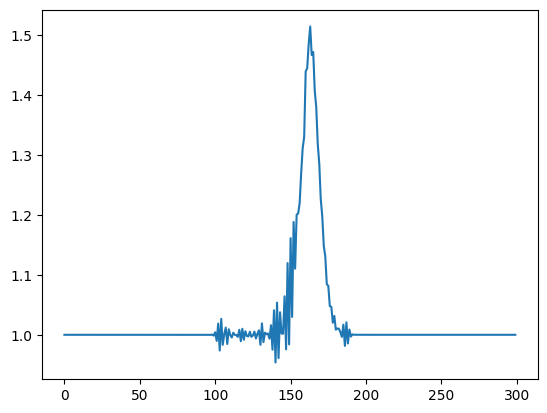

tensor(0.0025) tensor(1.3321)


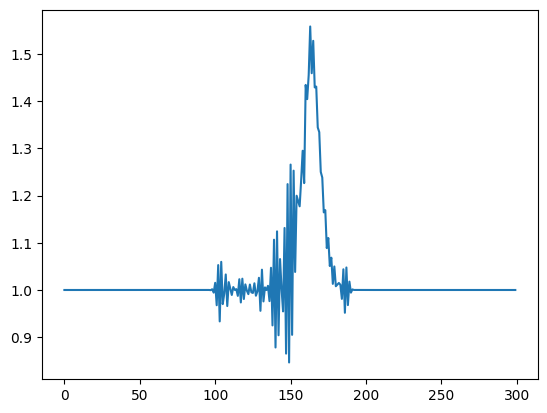

tensor(0.0025) tensor(1.3504)


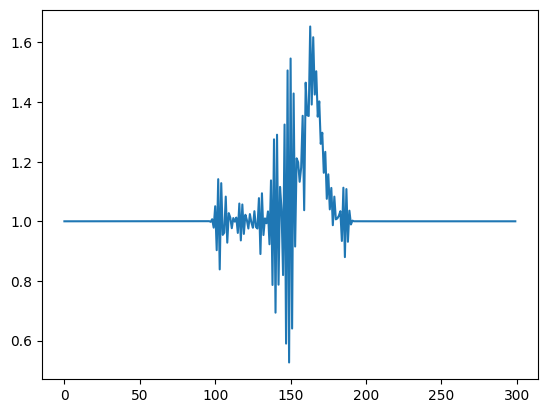

tensor(0.0024) tensor(1.4039)


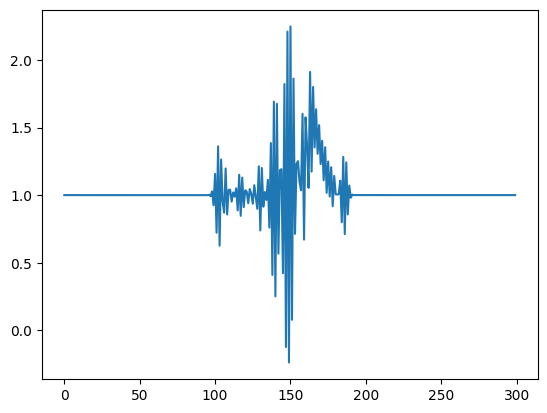

tensor(0.0016) tensor(2.1196)


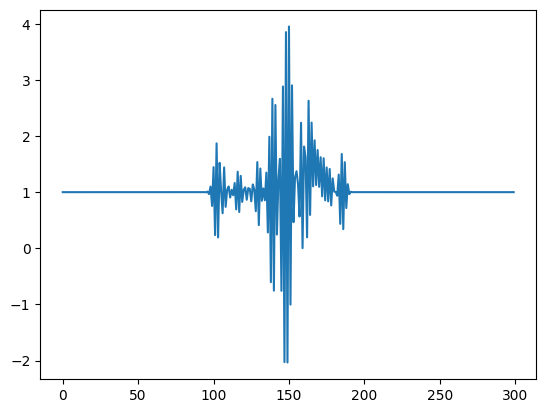

tensor(nan) tensor(nan)


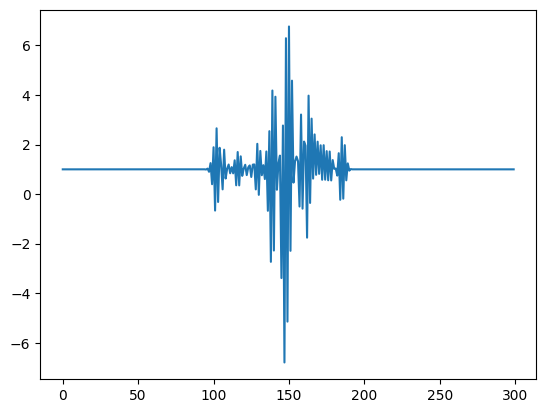

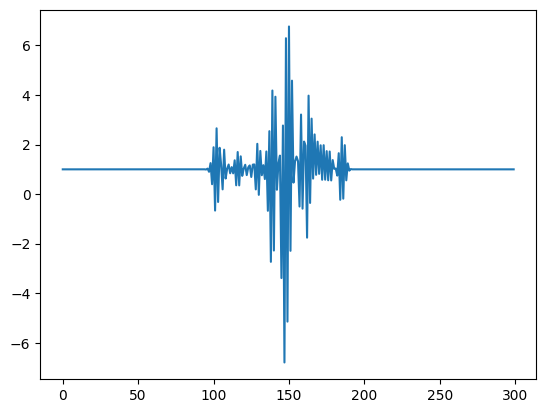

tensor(nan)


In [111]:
# Generate data for example
x = np.linspace(-5, 5, 300)
y = gaussian(0.25, 0, x) * 0.25

# Convert to torch tensors
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float() + 1.0

q_0 = torch.stack([y, torch.zeros_like(y)], dim=0) # torch.tensor of shape (2,N)
q_1 = shallow_water(q_0, 0.5, 1000)

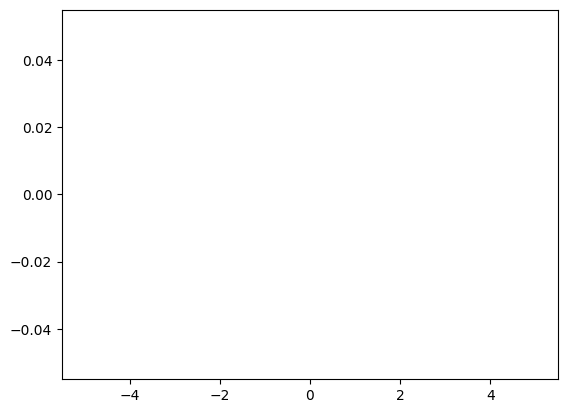

In [82]:
plt.plot(x, q_1[1,:])
#plt.plot(x, q_1[0,:])


### Junk (?)

We choose the parameter vector

$$
z = \frac{q}{\sqrt{h}}, \text{ so that } 
\begin{bmatrix}
z^1 \\
z^2
\end{bmatrix}
=
\begin{bmatrix}
\sqrt{h} \\
\sqrt{h}u
\end{bmatrix}

$$


In [23]:
# Initializing q
N = 10
h = torch.linspace(0,1,N+2)
u = torch.linspace(0.6,0.8,N+2)

q_0 = torch.stack([h,u*h], dim=0)
dt = 0.1
dx = 0.1


# Averaging on the interfaces
q_inter = torch.stack([(q_0[0,1:] + q_0[0,:-1]) / 2,
                       (q_0[1,1:] + q_0[1,:-1]) / 2], dim=0)

# Calculating the eigenvalues and eigenvectors
# Only need to store eigenvalues since eigenvectors are equal to (1, eigval)^T
eigval1, eigval2 = Jacobi_properties(q_inter)

# Solving the linear system
lhs = q_0[:,1:] - q_0[:,:-1]
alpha = torch.zeros(2, N+1)
for i in range(N+1):
    # type(torch.stack([torch.ones(2),torch.tensor([eigval1[i], eigval2[i]])], dim=0))
    alpha[:,i] = torch.linalg.solve(torch.stack([torch.ones(2),torch.tensor([eigval1[i], eigval2[i]])], dim=0), lhs[:,i])

# Calculating the waves
wave1 = alpha[0,:] * torch.stack([torch.ones(N+1), eigval1], dim=0)
wave2 = alpha[1,:] * torch.stack([torch.ones(N+1), eigval2], dim=0)

# Calculate the fluxuactions
A_plus = torch.zeros(2,N+1)
A_minus = torch.zeros(2,N+1)
for i in range(N+1):
    A_plus[:,i] = torch.max(torch.tensor(0), eigval1[i]) * wave1[:,i] + torch.max(torch.tensor(0), eigval2[i]) * wave2[:,i]
    A_minus[:,i] = torch.max(torch.tensor(0), -eigval1[i]) * wave1[:,i] + torch.max(torch.tensor(0), -eigval2[i]) * wave2[:,i]


# Updating q
q_1 = q_0.clone()
q_1[:,1:-1] = q_0[:,1:-1] - dt/dx * (A_plus[:,:-1] - A_minus[:,1:])

# Boundary conditions
...
print(q_0)
print(q_1)

# for i in range(N+1):
#     print(f"i = {i}:")
#     print(f"alpha = {alpha[:,i]}")
#     print(f"eigval1 = {eigval1[i]}")
#     print(f"eigval2 = {eigval2[i]}")
#     print(f"q1 = {lhs[0,i]}")
#     print(f"q2 = {lhs[1,i]}")
#     print()

tensor([[0.0000, 0.0909, 0.1818, 0.2727, 0.3636, 0.4545, 0.5455, 0.6364, 0.7273,
         0.8182, 0.9091, 1.0000],
        [0.0000, 0.0562, 0.1157, 0.1785, 0.2446, 0.3140, 0.3868, 0.4628, 0.5421,
         0.6248, 0.7107, 0.8000]])
tensor([[0.0000, 0.0347, 0.1223, 0.2099, 0.2975, 0.3854, 0.4744, 0.5618, 0.6492,
         0.7367, 0.8242, 1.0000],
        [0.0000, 0.0173, 0.0644, 0.1146, 0.1680, 0.2244, 0.2839, 0.3466, 0.4123,
         0.4812, 0.5533, 0.8000]])
